In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn import set_config
set_config(transform_output= 'pandas')

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [3]:
data= pd.read_csv('Data/cirrhosis.csv')
data.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [4]:
imputer= SimpleImputer(strategy= 'constant')
imputer.fit(data)
df= imputer.transform(data)

In [5]:
df.isna().sum()

ID               0
N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

In [6]:
df['Age']= df['Age']/365
df

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,58.805479,F,Y,Y,Y,Y,14.5,261.0,2.6,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,56.484932,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,70.120548,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.1,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,54.778082,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,38.131507,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,681,D,missing_value,67.046575,F,missing_value,missing_value,missing_value,N,1.2,missing_value,2.96,missing_value,missing_value,missing_value,missing_value,174.0,10.9,3.0
414,415,1103,C,missing_value,39.027397,F,missing_value,missing_value,missing_value,N,0.9,missing_value,3.83,missing_value,missing_value,missing_value,missing_value,180.0,11.2,4.0
415,416,1055,C,missing_value,57.038356,F,missing_value,missing_value,missing_value,N,1.6,missing_value,3.42,missing_value,missing_value,missing_value,missing_value,143.0,9.9,3.0
416,417,691,C,missing_value,58.041096,F,missing_value,missing_value,missing_value,N,0.8,missing_value,3.75,missing_value,missing_value,missing_value,missing_value,269.0,10.4,3.0


In [7]:
df = df.groupby('Status').size()
df

Status
C     232
CL     25
D     161
dtype: int64

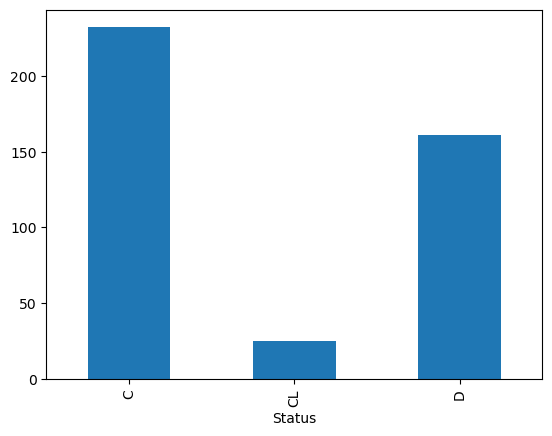

In [8]:
df.plot.bar(x='Status', y='Bilirubin')
plt.show()

In [9]:
# PREPROCESSING

target='Status'

drop_cols= ['ID']

X = df.drop(columns=[target] + drop_cols)
y= df[target].copy()

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42)

KeyError: 'Status'

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols), 
        ('cat', OneHotEncoder(sparse_output= False), cat_cols)], verbose_feature_names_out= False)

preprocessor.fit(X_train)

X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
rf_df = RandomForestClassifier(random_state=42)

rf_df.fit(X_train_preprocessed, y_train)

evaluate_classification(rf_df, X_train_preprocessed, y_train, X_test_preprocessed, y_test)

In [ ]:
from sklearn.inspection import permutation_importance

# Permutation importance takes a fit model and the test data.
r = permutation_importance(rf_df, X_test_preprocessed, y_test,n_repeats =10, random_state = 42)
r.keys()

In [ ]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=rf_df.feature_names_in_,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

In [ ]:
# EXPLANATORY VISUALIZATIONS

In [ ]:
# Feature 1 Viz
plt.figure(figsize=(12, 6))

df.plot.bar(x='Status', y='Bilirubin')

plt.xlabel('Status')
plt.ylabel('Level of Bilirubin')
plt.title(f'Status of Patients with Varying Levels of Bilirubin')

With this scatterplot we can see the range of different people's ages that took either the D- penicillamine vs the placebo.

In [ ]:
# Feature 2 Viz
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
sns.scatterplot(x=df['Status'], y=df['Drug'], hue=df['Bilirubin'])
plt.xlabel(feature2)
plt.ylabel('Level of Bilirubin')
plt.title(f'Scatter Plot of {feature2} vs. Target')

With this scatterplot we can visualize the differnt levels of Bilirubin of the patients that took the D- penicillamine vs the Placebo.